In [365]:
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
import matplotlib.pyplot as plt


In [366]:
from copy import deepcopy
from IPython.display import clear_output

class Polygon:
   def __init__(self, vertices = 3, high = [256, 256]):
      self.cords = np.random.randint(low=[0,0], high=high, size = (vertices, 2))
      self.rgba = np.random.randint(256, size = 4)
      

class ImageGA:
   def __init__(self, image, gif_name = "default", iterations=100000, population_size=50, individual_size=60, polygon_vertices = 3, children_size = 50):
      self.og_image = image
      self.og_image_data = np.asarray(self.og_image, dtype=np.int32)
      self.img_w, self.img_h = self.og_image.size
      self.iterations = iterations
      self.population_size = population_size
      self.children_size = children_size
      self.individual_size = individual_size
      self.gif_name = gif_name
      self.population = []
      self.fitness_history = []
      self.gif_frames = []
      self.polygon_vertices = polygon_vertices

   def get_individual(self):
      return np.array([Polygon(self.polygon_vertices, [self.img_w, self.img_h]) for _ in range(self.individual_size)])

   def get_random_population(self):
      return np.array([self.get_individual() for _ in range(self.population_size)])

   def mutate(self, individual): # TO DO
      for pol in individual:
         t = np.random.random()
         if t < 0.5: # change color
            id = np.random.randint(
                low=0, high=4, size=1)
            pol.rgba[id] = np.random.randint(
                low=0, high=256, size=1)
         else: # change cords
            id = np.random.randint(
                low=0, high=self.polygon_vertices, size = 1)
            new_cords = np.random.randint(
                low=[0, 0], high=[self.img_w, self.img_h], size=(1, 2))
            pol.cords[id] = new_cords
      return individual

   def get_image(self, individual):
      image = Image.new("RGB", (self.img_w, self.img_h))
      draw = ImageDraw.Draw(image, "RGBA")
      for pol in individual:
         draw.polygon(tuple(map(tuple, pol.cords)), tuple(pol.rgba))
      return image

   def objective_function(self, individual):
      image_data = np.asarray(self.get_image(individual), dtype=np.int32)
      return 100*(1.0 - np.sum(abs(image_data - self.og_image_data) / (self.img_h * self.img_w * 3 * 255)))

   def parents_selection(self, population_values):
      return self.best_idx(population_values)
   
   def crossover(self, p1, p2):
      c1 = deepcopy(p1)
      c2 = deepcopy(p2)
      middle_point = self.individual_size // 2
      return np.concatenate((c1[:middle_point], c2[middle_point:]))

   def get_children(self, parents_idx):
      children = []
      for _ in range(self.children_size):
         p1, p2 = np.random.choice(parents_idx, size = 2, replace=True)
         children.append(self.crossover(self.population[p1], self.population[p2]))
      return np.array(children)

   def best_idx(self, p_v):
       return np.argpartition(p_v, -self.population_size)[-self.population_size:]
   
   def run(self):
      self.population = self.get_random_population()
      for t in tqdm(range(self.iterations), desc=f'Evolving'):
         population_values = np.array([self.objective_function(x) for x in self.population])
         self.fitness_history.append(
             (population_values.min(), population_values.mean(), population_values.max()))
         parents_idx = self.parents_selection(population_values)

         children = self.get_children(parents_idx)
         children = np.array([self.mutate(c) for c in children])
          
         candidates = np.concatenate((self.population, children))
         candidates_values = np.array([self.objective_function(x) for x in candidates])

         self.population = candidates[self.best_idx(candidates_values)]
         population_values = np.array(
             [self.objective_function(x) for x in self.population])
         best_guy = candidates[candidates_values.argmax()]

         gif_frame = self.get_image(best_guy)
         if t % 10 == 0:
            clear_output(wait=True)
            plt.imshow(gif_frame)
            plt.show()

         gif_frame.save(self.gif_name + '.png', quality='keep')
         self.gif_frames.append(gif_frame)
      
      self.gif_frames[0].save(self.gif_name+'.gif', format='GIF',
                                 append_images=self.gif_frames[1:], save_all=True, duration=4, loop=0)


         


In [367]:
from copy import deepcopy
from IPython.display import clear_output

class Polygon:
   def __init__(self, vertices = 3, high = [256, 256]):
      self.cords = np.random.randint(low=[0,0], high=high, size = (vertices, 2))
      self.rgba = np.random.randint(256, size = 4)
      

class ImageGA2:
   def __init__(self, image, gif_name = "default", iterations=100000, population_size=20, individual_size=100, polygon_vertices = 3, children_size = 100, tick = 100):
      self.og_image = image
      self.og_image_data = np.asarray(self.og_image, dtype=np.int32)
      self.img_w, self.img_h = self.og_image.size
      self.iterations = iterations
      self.population_size = population_size
      self.children_size = children_size
      self.individual_size = individual_size
      self.gif_name = gif_name
      self.population = []
      self.fitness_history = []
      self.gif_frames = []
      self.polygon_vertices = polygon_vertices
      self.tick = tick
      self.global_best = 100000000000

   def get_individual(self):
      return np.array([Polygon(self.polygon_vertices, [self.img_w, self.img_h]) for _ in range(self.individual_size)])

   def get_random_population(self):
      return np.array([self.get_individual() for _ in range(self.population_size)])

   def mutate(self, individual): # TO DO
      for pol in individual:
         for i in range(4):
            pol.rgba[i] = np.random.randint(low=max(pol.rgba[i]-30,0), high=min(pol.rgba[i]+30, 256))
         id = np.random.randint(
             low=0, high=self.polygon_vertices, size = 1)
         new_cords = np.random.randint(
             low=[max(pol.cords[id][0][0] - 30, 0), max(pol.cords[id][0][1] - 30, 0)], high=[min(pol.cords[id][0][0] + 30, self.img_w), min(pol.cords[id][0][1] + 30, self.img_h)], size=(1, 2))
         pol.cords[id] = new_cords
      return individual

   def get_image(self, individual):
      image = Image.new("RGB", (self.img_w, self.img_h))
      draw = ImageDraw.Draw(image, "RGBA")
      for pol in individual:
         draw.polygon(tuple(map(tuple, pol.cords)), tuple(pol.rgba))
      return image

   def objective_function(self, individual):
      image_data = np.asarray(self.get_image(individual), dtype=np.int32)
      return np.sum((image_data - self.og_image_data)**2 / (self.img_w * self.img_h))

   def parents_selection(self, population_values):
      if np.sum(np.abs(population_values)) == 0:
        prop = np.ones(len(population_values)) / len(population_values)
      else:
         prop = np.abs(population_values) / (np.sum(np.abs(population_values)))  # normalization

      parents_idx = np.zeros(self.population_size)
      for i in range(self.population_size // 2):
         parents_idx[i] = np.random.choice(
             np.arange(len(prop)), p=prop, replace=True)  # roulette
      return parents_idx.astype(int)
   
   def crossover(self, p1, p2):
      c1 = deepcopy(p1)
      c2 = deepcopy(p2)
      middle_point = self.individual_size // 2
      return np.concatenate((c1[:middle_point], c2[middle_point:]))

   def get_children(self, parents_idx):
      children = []
      for _ in range(self.children_size):
         p1, p2 = np.random.choice(parents_idx, size = 2, replace=True)
         children.append(self.crossover(self.population[p1], self.population[p2]))
      return np.array(children)

   def best_idx(self, p_v):
       return np.argpartition(p_v, self.population_size)[:self.population_size]
   
   def run(self):
      self.population = self.get_random_population()
      for t in tqdm(range(self.iterations), desc=f'Evolving'):
         population_values = np.array([self.objective_function(x) for x in self.population])
         self.fitness_history.append(
             (population_values.min(), population_values.mean(), population_values.max()))
         parents_idx = self.parents_selection(population_values)

         children = self.get_children(parents_idx)
         children = np.array([self.mutate(c) for c in children])
          
         candidates = np.concatenate((self.population, children))
         candidates_values = np.array([self.objective_function(x) for x in candidates])

         self.population = candidates[self.best_idx(candidates_values)]
         population_values = np.array(
             [self.objective_function(x) for x in self.population])
         best_guy = candidates[candidates_values.argmin()]
         self.global_best = min(self.global_best, candidates_values.min())

         gif_frame = self.get_image(best_guy)
         if t % self.tick == 0:
            gif_frame.save(self.gif_name + '.png', quality='keep')
            clear_output(wait=True)
            plt.imshow(gif_frame)
            plt.show()

         if t % 10: 
            self.gif_frames.append(gif_frame)

      gif_frame.save(self.gif_name + '.png', quality='keep')
      self.gif_frames.append(gif_frame)
      self.gif_frames[0].save(self.gif_name+'.gif', format='GIF',
                                 append_images=self.gif_frames[1:], save_all=True, duration=4, loop=0)

   def plot_cost(self):
       plt.figure(figsize=(15, 5))
       plt.plot(self.fitness_history)
       plt.title(
           f'BEST: {self.global_best :.3f}')
       plt.legend(['Min', 'Mean', 'Max'], loc='upper right')


         


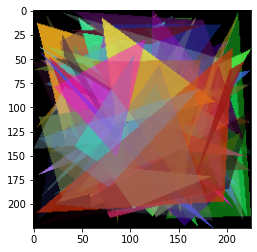

Evolving:   2%|▏         | 17/1000 [00:25<24:09,  1.47s/it]


KeyboardInterrupt: 

In [368]:
img = Image.open("../images/easy225x225.png").convert("RGB")
s = ImageGA2(img, gif_name="easy225x225", iterations=1000)
s.run()


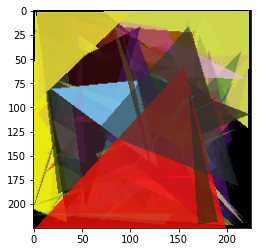

Evolving: 100%|██████████| 25000/25000 [6:34:53<00:00,  1.06it/s]


In [ ]:
s = ImageGA2(img, gif_name="easy225x225", iterations=25000)
s.run()


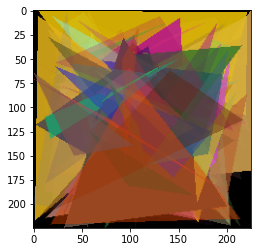

Evolving: 100%|██████████| 2500/2500 [40:00<00:00,  1.04it/s]


In [ ]:
s = ImageGA2(img, gif_name="easy225x225", iterations=2500)
s.run()


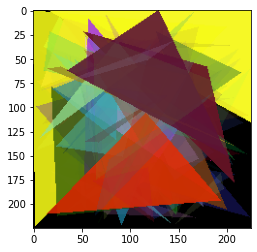

Evolving: 100%|██████████| 2500/2500 [41:06<00:00,  1.01it/s]


In [ ]:
s = ImageGA2(img, gif_name="easy225x225", iterations=2500)
s.run()


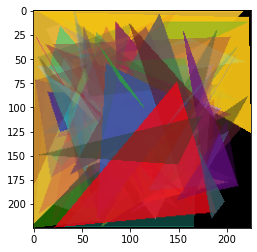

Evolving: 100%|██████████| 1000/1000 [23:33<00:00,  1.41s/it]


In [ ]:
s = ImageGA2(img,population_size=20, children_size=100, tick=20, gif_name="easy225x225", iterations=1000)
s.run()


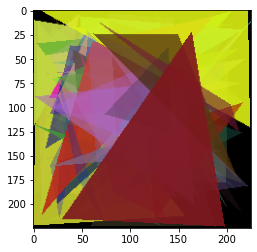

Evolving: 100%|██████████| 500/500 [20:59<00:00,  2.52s/it]


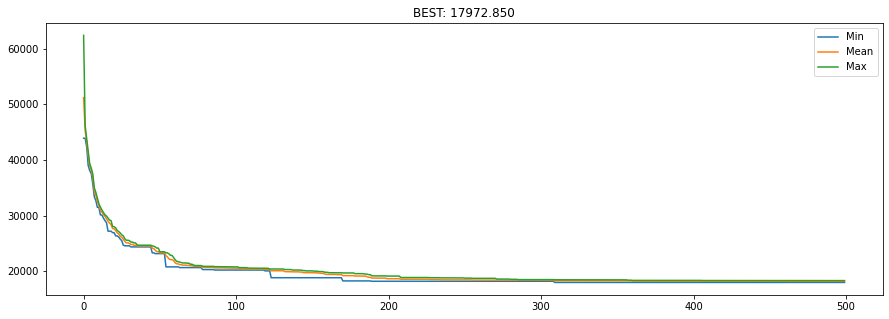

In [ ]:
s = ImageGA2(img, population_size=8, children_size=200,
             tick=20, gif_name="easy225x225", iterations=500)
s.run()
s.plot_cost()


In [ ]:
class ImageGA3:
   def __init__(self, image, gif_name="default", iterations=100000, population_size=20, individual_size=100, polygon_vertices=3, children_size=100, tick=100):
      self.og_image = image
      self.og_image_data = np.asarray(self.og_image, dtype=np.int32)
      self.img_w, self.img_h = self.og_image.size
      self.iterations = iterations
      self.population_size = population_size
      self.children_size = children_size
      self.individual_size = individual_size
      self.gif_name = gif_name
      self.population = []
      self.fitness_history = []
      self.gif_frames = []
      self.polygon_vertices = polygon_vertices
      self.tick = tick
      self.global_best = 100000000000

   def get_individual(self):
      return np.array([Polygon(self.polygon_vertices, [self.img_w, self.img_h]) for _ in range(self.individual_size)])

   def get_random_population(self):
      return np.array([self.get_individual() for _ in range(self.population_size)])

   def mutate(self, individual):  # TO DO
      for pol in individual:
         for i in range(4):
            pol.rgba[i] = np.random.randint(
                low=max(pol.rgba[i]-30, 0), high=min(pol.rgba[i]+30, 256))
         id = np.random.randint(
             low=0, high=self.polygon_vertices, size=1)
         new_cords = np.random.randint(
             low=[max(pol.cords[id][0][0] - 30, 0), max(pol.cords[id][0][1] - 30, 0)], high=[min(pol.cords[id][0][0] + 30, self.img_w), min(pol.cords[id][0][1] + 30, self.img_h)], size=(1, 2))
         pol.cords[id] = new_cords
      return individual

   def get_image(self, individual):
      image = Image.new("RGB", (self.img_w, self.img_h))
      draw = ImageDraw.Draw(image, "RGBA")
      for pol in individual:
         draw.polygon(tuple(map(tuple, pol.cords)), tuple(pol.rgba))
      return image

   def objective_function(self, individual):
      image_data = np.asarray(self.get_image(individual), dtype=np.int32)
      return np.sum((image_data - self.og_image_data)**2 / (self.img_w * self.img_h))

   def crossover(self, p1, p2):
      c1 = deepcopy(p1)
      c2 = deepcopy(p2)
      middle_point = self.individual_size // 2
      return np.concatenate((c1[:middle_point], c2[middle_point:]))

   def get_children(self, parents_idx):
      children = []
      for _ in range(self.children_size):
         p1, p2 = np.random.choice(parents_idx, size=2, replace=True)
         children.append(self.crossover(
             self.population[p1], self.population[p2]))
      return np.array(children)

   def best_idx(self, p_v):
       return np.argpartition(p_v, self.population_size)[:self.population_size]

   def run(self):
      self.population = self.get_random_population()
      for t in tqdm(range(self.iterations), desc=f'Evolving'):
         population_values = np.array(
             [self.objective_function(x) for x in self.population])
         self.fitness_history.append(
             (population_values.min(), population_values.mean(), population_values.max()))

         children = self.get_children(np.arange(self.population_size))
         children = np.array([self.mutate(c) if np.random.random() < 0.7 else self.get_individual() for c in children])

         candidates = np.concatenate((self.population, children))
         candidates_values = np.array(
             [self.objective_function(x) for x in candidates])

         self.population = candidates[self.best_idx(candidates_values)]
         population_values = np.array(
             [self.objective_function(x) for x in self.population])
         best_guy = candidates[candidates_values.argmin()]
         self.global_best = min(self.global_best, candidates_values.min())

         gif_frame = self.get_image(best_guy)
         if t % self.tick == 0:
            gif_frame.save(self.gif_name + '.png', quality='keep')
            clear_output(wait=True)
            plt.imshow(gif_frame)
            plt.show()

         if t % 10:
            self.gif_frames.append(gif_frame)

      gif_frame.save(self.gif_name + '.png', quality='keep')
      self.gif_frames.append(gif_frame)
      self.gif_frames[0].save(self.gif_name+'.gif', format='GIF',
                              append_images=self.gif_frames[1:], save_all=True, duration=4, loop=0)

   def plot_cost(self):
       plt.figure(figsize=(15, 5))
       plt.plot(self.fitness_history)
       plt.title(
           f'BEST: {self.global_best :.3f}')
       plt.legend(['Min', 'Mean', 'Max'], loc='upper right')


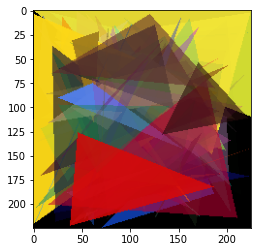

Evolving: 100%|██████████| 2500/2500 [1:42:17<00:00,  2.45s/it]


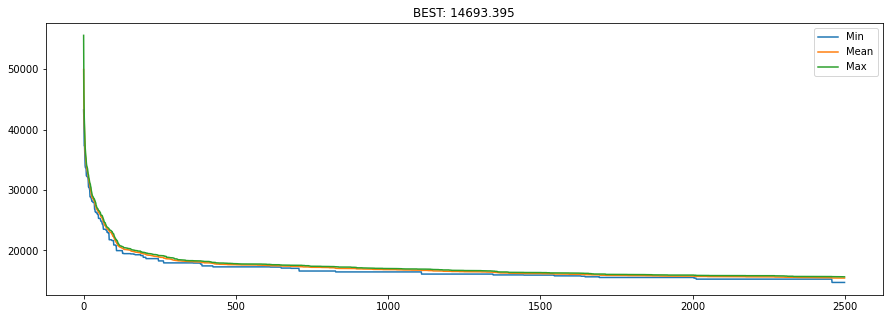

In [ ]:
s = ImageGA3(img, population_size=20, children_size=200,
             tick=20, gif_name="easy225x225", iterations=2500)
s.run()
s.plot_cost()


In [ ]:
class Polygon:
   def __init__(self, vertices=3, high=[256, 256]):
      self.cords = np.random.randint(low=[0, 0], high=high, size=(vertices, 2))
      self.rgba = np.random.randint(256, size=4)

class ImageGA4:
   def __init__(self, image, gif_name="default", iterations=100000, population_size=20, individual_size=100, polygon_vertices=3, children_size=100, tick=100, sigma=0.01):
      self.og_image = image
      self.og_image_data = np.asarray(self.og_image, dtype=np.int32)
      self.img_w, self.img_h = self.og_image.size
      self.iterations = iterations
      self.population_size = population_size
      self.children_size = children_size
      self.individual_size = individual_size
      self.gif_name = gif_name
      self.population = []
      self.fitness_history = []
      self.gif_frames = []
      self.polygon_vertices = polygon_vertices
      self.tick = tick
      self.global_best = 100000000000
      self.sigma = sigma

   def get_individual(self):
      return np.array([Polygon(self.polygon_vertices, [self.img_w, self.img_h]) for _ in range(self.individual_size)])

   def get_random_population(self):
      return np.array([self.get_individual() for _ in range(self.population_size)])

   def mutate(self, individual):  # TO DO
      for pol in individual:
         for i in range(4):
            pol.rgba[i] = min(max(0,np.random.normal(pol.rgba[i], 15)), 255)
         id = np.random.randint(
             low=0, high=self.polygon_vertices, size=1)

         new_cords = np.random.normal(pol.cords[id], [self.img_w / 8, self.img_w / 8])
         new_cords[new_cords < 0] = 0
         if new_cords[0][0] > self.img_w:
            new_cords[0][0] = self.img_w
         if new_cords[0][1] > self.img_h:
            new_cords[0][1] = self.img_h
         pol.cords[id] = new_cords
      return individual

   def get_image(self, individual):
      image = Image.new("RGB", (self.img_w, self.img_h))
      draw = ImageDraw.Draw(image, "RGBA")
      for pol in individual:
         draw.polygon(tuple(map(tuple, pol.cords)), tuple(pol.rgba))
      return image

   def objective_function(self, individual):
      image_data = np.asarray(self.get_image(individual), dtype=np.int32)
      return np.sum((image_data - self.og_image_data)**2 / (self.img_w * self.img_h))

   def crossover(self, p1, p2):
      c1 = deepcopy(p1)
      c2 = deepcopy(p2)
      middle_point = max(min(5,np.random.normal(self.individual_size // 2, 5)), self.individual_size - 5)
      return np.concatenate((c1[:middle_point], c2[middle_point:]))

   def get_children(self, parents_idx):
      children = []
      for _ in range(self.children_size):
         p1, p2 = np.random.choice(parents_idx, size=2, replace=True)
         children.append(self.crossover(
             self.population[p1], self.population[p2]))
      return np.array(children)

   def best_idx(self, p_v, k):
       return np.argpartition(p_v, k)[:k]

   def run(self):
      self.population = self.get_random_population()
      for t in tqdm(range(self.iterations), desc=f'Evolving'):
         population_values = np.array(
             [self.objective_function(x) for x in self.population])
         self.fitness_history.append(
             (population_values.min(), population_values.mean(), population_values.max()))

         children = self.get_children(np.arange(self.population_size))
         children = np.array([self.mutate(c) if np.random.random(
         ) < 0.9 else self.get_individual() for c in children])

         top_pop = self.population[self.best_idx(population_values, 3)] # elitism
         candidates = np.concatenate((top_pop, children))
         candidates_values = np.array(
             [self.objective_function(x) for x in candidates])

         self.population = candidates[self.best_idx(candidates_values, self.population_size)]
         population_values = np.array(
             [self.objective_function(x) for x in self.population])
         best_guy = candidates[candidates_values.argmin()]
         self.global_best = min(self.global_best, candidates_values.min())

         gif_frame = self.get_image(best_guy)
         if t % self.tick == 0:
            gif_frame.save(self.gif_name + '.png', quality='keep')
            clear_output(wait=True)
            plt.imshow(gif_frame)
            plt.show()

         if t % 10:
            self.gif_frames.append(gif_frame)

      gif_frame.save(self.gif_name + '.png', quality='keep')
      self.gif_frames.append(gif_frame)
      self.gif_frames[0].save(self.gif_name+'.gif', format='GIF',
                              append_images=self.gif_frames[1:], save_all=True, duration=4, loop=0)

   def plot_cost(self):
       plt.figure(figsize=(15, 5))
       plt.plot(self.fitness_history)
       plt.title(f'BEST: {self.global_best :.3f}')
       plt.legend(['Min', 'Mean', 'Max'], loc='upper right')


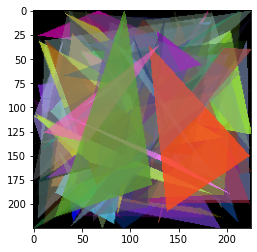

Evolving:   0%|          | 3/20000 [00:08<15:12:18,  2.74s/it]


KeyboardInterrupt: 

In [ ]:
s = ImageGA4(img, population_size=20, children_size=200,
             tick=50, gif_name="easy225x225", iterations=20000)
s.run()
s.plot_cost()


In [375]:
class ImageGAIncremental:
   def __init__(self, image, gif_name="default", iterations=100000, population_size=3, individual_size=2, polygon_vertices=3, children_size=150, tick=100, to_mutate = 2, increment = 100):
      self.og_image = image
      self.og_image_data = np.asarray(self.og_image, dtype=np.int32)
      self.img_w, self.img_h = self.og_image.size
      self.iterations = iterations
      self.population_size = population_size
      self.children_size = children_size
      self.individual_size = individual_size
      self.gif_name = gif_name
      self.population = []
      self.fitness_history = []
      self.gif_frames = []
      self.polygon_vertices = polygon_vertices
      self.tick = tick
      self.global_best = 100000000000
      self.to_mutate = to_mutate
      self.increment = increment

   def get_individual(self):
      return np.array([Polygon(self.polygon_vertices, [self.img_w, self.img_h]) for _ in range(self.individual_size)])

   def get_random_population(self):
      return np.array([self.get_individual() for _ in range(self.population_size)])

   def mutate(self, individual_og):
      individual = deepcopy(individual_og)
      for j in range(individual.size - self.to_mutate, individual.size):
         pol = individual[j]
         for i in range(4):
            pol.rgba[i] = min(max(0, np.random.normal(pol.rgba[i], 15)), 255)
         id = np.random.randint(
             low=0, high=self.polygon_vertices, size=1)

         new_cords = np.random.normal(
             pol.cords[id], [self.img_w / 8, self.img_w / 8])
         new_cords[new_cords < 0] = 0
         if new_cords[0][0] > self.img_w:
            new_cords[0][0] = self.img_w
         if new_cords[0][1] > self.img_h:
            new_cords[0][1] = self.img_h
         pol.cords[id] = new_cords
      return individual

   def get_image(self, individual):
      image = Image.new("RGB", (self.img_w, self.img_h))
      draw = ImageDraw.Draw(image, "RGBA")
      for pol in individual:
         draw.polygon(tuple(map(tuple, pol.cords)), tuple(pol.rgba))
      return image

   def objective_function(self, individual):
      image_data = np.asarray(self.get_image(individual), dtype=np.int32)
      return np.sum((image_data - self.og_image_data)**2 / (self.img_w * self.img_h))

   def best_idx(self, p_v, k):
       return np.argpartition(p_v, k)[:k]

   def run(self):
      self.population = self.get_random_population()
      for t in tqdm(range(self.iterations), desc=f'Evolving'):
         if (t + 1) % self.increment == 0:
            self.individual_size += 1
            arr = np.array([Polygon()] * self.population_size)
            self.population = np.concatenate((self.population, arr[:, None]), axis=1)

         population_values = np.array(
             [self.objective_function(x) for x in self.population])
         self.population = np.array([self.population[i] for i,_ in sorted(enumerate(population_values), key=lambda x: x[1])])
         population_values.sort()

         self.fitness_history.append(
             (population_values.min(), population_values.mean(), population_values.max()))

         new_population = []

         for i in range(self.population_size):
            for j in range(self.children_size):
               new_population.append(self.mutate(self.population[i]))

         new_population = np.array(new_population)
         new_population_values = np.array(
             [self.objective_function(x) for x in new_population])
         new_population = np.array([new_population[i] for i, _ in sorted(
             enumerate(new_population_values), key=lambda x: x[1])])
         new_population_values.sort()

         self.population = np.concatenate((self.population, new_population))
         population_values = np.concatenate((population_values, new_population_values))

         self.population = np.array([self.population[i] for i, _ in sorted(
             enumerate(population_values), key=lambda x: x[1])][:self.population_size])

         best_guy = self.population[0]
         self.global_best = min(self.global_best, population_values[0])

         gif_frame = self.get_image(best_guy)
         if t % self.tick == 0:
            gif_frame.save(self.gif_name + '.png', quality='keep')
            self.gif_frames.append(gif_frame)
         
         if (t + 1) % 1000 == 0:
            self.increment += 10 # more time for fine tuning in later stages

      gif_frame.save(self.gif_name + '.png', quality='keep')
      self.gif_frames.append(gif_frame)
      self.gif_frames[0].save(self.gif_name+'.gif', format='GIF',
                              append_images=self.gif_frames[1:], save_all=True, duration=4, loop=0)

   def plot_cost(self):
       plt.figure(figsize=(20, 10))
       plt.plot(self.fitness_history)
       plt.title(f'BEST: {self.global_best :.3f}')
       plt.legend(['Min', 'Mean', 'Max'], loc='upper right')


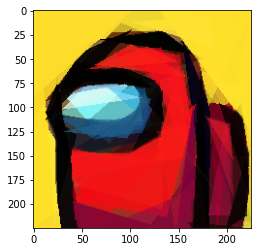

Evolving: 100%|██████████| 5000/5000 [1:16:43<00:00,  1.09it/s]


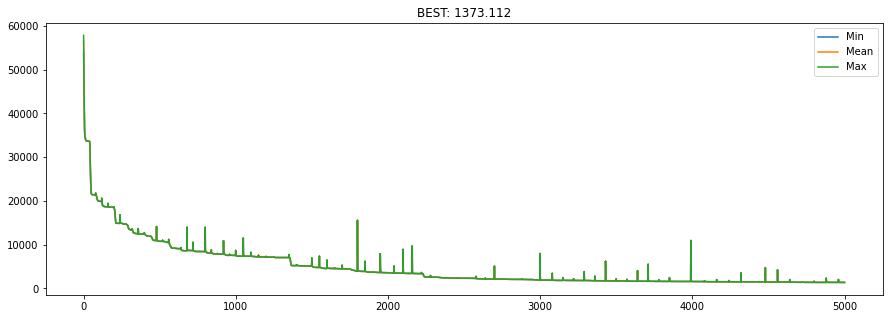

In [ ]:
s = ImageGAIncremental(img, population_size=3, children_size=150,
             tick=10, gif_name="easy225x225", iterations=5000, increment=40)
s.run()
s.plot_cost()


Evolving:   0%|          | 0/5000 [00:00<?, ?it/s]

number of triangles in previous run:  91


Evolving: 100%|██████████| 5000/5000 [1:23:44<00:00,  1.00s/it]


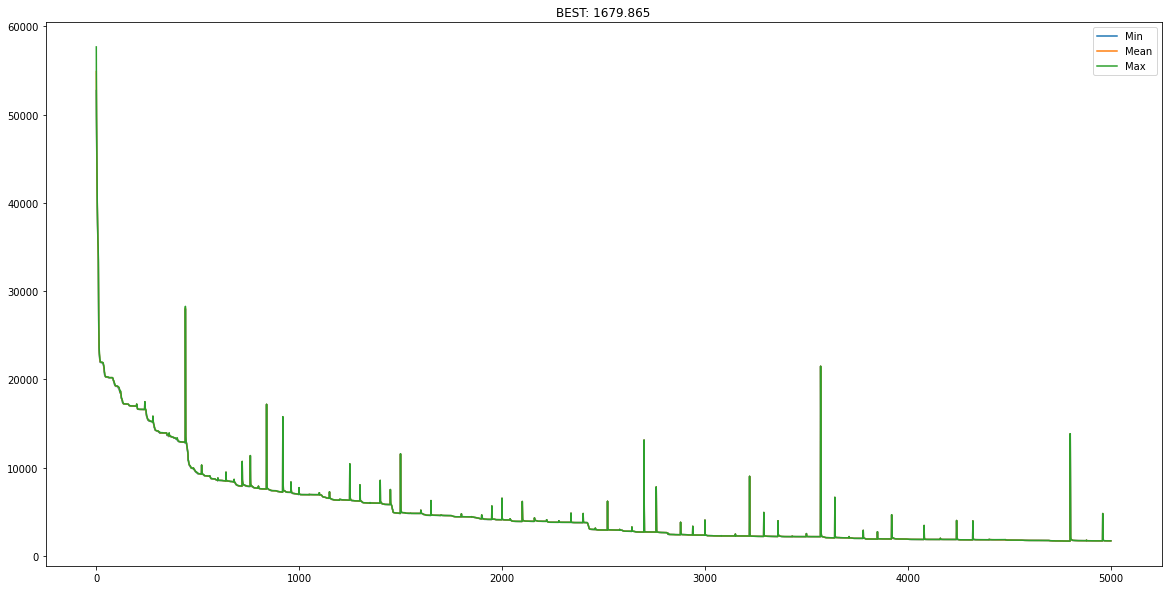

In [ ]:
print("number of triangles in previous run: ", s.individual_size)


t = ImageGAIncremental(img, population_size=3, children_size=150,
                       tick=10, gif_name="easy225x225inc5000mut3", iterations=5000, increment=40, to_mutate=3, individual_size=3)
t.run()
t.plot_cost()


In [426]:
class Polygon:
   def __init__(self, vertices=3, high=[256, 256]):
      self.cords = np.random.randint(low=[0, 0], high=high, size=(vertices, 2))
      # self.rgba = np.random.randint(256, size=4)
      self.rgba = np.random.normal(128, 50, size = 4).astype(int)

class ImageGAIncremental2:
   def __init__(self, image, gif_name="default", iterations=100000, population_size=3, individual_size=2, polygon_vertices=3, children_size=150, tick=100, to_mutate=2, increment=100):
      self.og_image = image
      self.og_image_data = np.asarray(self.og_image, dtype=np.int32)
      self.img_w, self.img_h = self.og_image.size
      self.iterations = iterations
      self.population_size = population_size
      self.children_size = children_size
      self.individual_size = individual_size
      self.gif_name = gif_name
      self.population = []
      self.fitness_history = []
      self.gif_frames = []
      self.polygon_vertices = polygon_vertices
      self.tick = tick
      self.global_best = 100000000000
      self.to_mutate = to_mutate
      self.increment = increment

   def get_individual(self):
      return np.array([Polygon(self.polygon_vertices, [self.img_w, self.img_h]) for _ in range(self.individual_size)])

   def get_random_population(self):
      return np.array([self.get_individual() for _ in range(self.population_size)])

   def mutate(self, individual_og):
      individual = deepcopy(individual_og)
      id = np.random.randint(low=individual.size -
                             self.to_mutate, high=individual.size)
      pol = individual[id]
      for i in range(4):
         pol.rgba[i] = min(max(0, np.random.normal(pol.rgba[i], 15)), 255)
      id = np.random.randint(
          low=0, high=self.polygon_vertices, size=1)

      new_cords = np.random.normal(
          pol.cords[id], [self.img_w / 8, self.img_h / 8])
      new_cords[new_cords < 0] = 0
      if new_cords[0][0] > self.img_w:
         new_cords[0][0] = self.img_w
      if new_cords[0][1] > self.img_h:
         new_cords[0][1] = self.img_h
      pol.cords[id] = new_cords
      return individual

   def get_image(self, individual):
      image = Image.new("RGB", (self.img_w, self.img_h))
      draw = ImageDraw.Draw(image, "RGBA")
      for pol in individual:
         draw.polygon(tuple(map(tuple, pol.cords)), tuple(pol.rgba))
      return image

   def objective_function(self, individual):
      image_data = np.asarray(self.get_image(individual), dtype=np.int32)
      return np.sum((image_data - self.og_image_data)**2 / (self.img_w * self.img_h))

   def best_idx(self, p_v, k):
       return np.argpartition(p_v, k)[:k]

   def run(self):
      self.population = self.get_random_population()
      for t in tqdm(range(self.iterations), desc=f'Evolving'):
         if (t + 1) % self.increment == 0:
            self.individual_size += 1
            arr = np.array([Polygon(self.polygon_vertices, [self.img_w, self.img_h]) for _ in range(self.population_size)])
            self.population = np.concatenate(
                (self.population, arr[:, None]), axis=1)

         population_values = np.array(
             [self.objective_function(x) for x in self.population])
         self.population = np.array([self.population[i] for i, _ in sorted(
             enumerate(population_values), key=lambda x: x[1])])
         population_values.sort()

         self.fitness_history.append(
             (population_values.min(), population_values.mean(), population_values.max()))

         new_population = []

         for i in range(self.population_size):
            for j in range(self.children_size):
               new_population.append(self.mutate(self.population[i]))

         new_population = np.array(new_population)
         new_population_values = np.array(
             [self.objective_function(x) for x in new_population])
         new_population = np.array([new_population[i] for i, _ in sorted(
             enumerate(new_population_values), key=lambda x: x[1])])
         new_population_values.sort()

         self.population = np.concatenate((self.population, new_population))
         population_values = np.concatenate(
             (population_values, new_population_values))

         self.population = np.array([self.population[i] for i, _ in sorted(
             enumerate(population_values), key=lambda x: x[1])][:self.population_size])

         best_guy = self.population[0]
         self.global_best = min(self.global_best, population_values[0])

         gif_frame = self.get_image(best_guy)
         if t % self.tick == 0:
            gif_frame.save(self.gif_name + '.png', quality='keep')
            self.gif_frames.append(gif_frame)

         if (t + 1) % 1000 == 0:
            self.increment += 10  # more time for fine tuning in later stages

      gif_frame.save(self.gif_name + '.png', quality='keep')
      self.gif_frames.append(gif_frame)
      self.gif_frames[0].save(self.gif_name+'.gif', format='GIF',
                              append_images=self.gif_frames[1:], save_all=True, duration=4, loop=0)

   def plot_cost(self):
       plt.figure(figsize=(20, 10))
       plt.plot(self.fitness_history)
       plt.title(f'BEST: {self.global_best :.3f}')
       plt.legend(['Min', 'Mean', 'Max'], loc='upper right')


Evolving: 100%|██████████| 1000/1000 [05:41<00:00,  2.93it/s]


number of triangles used:  28


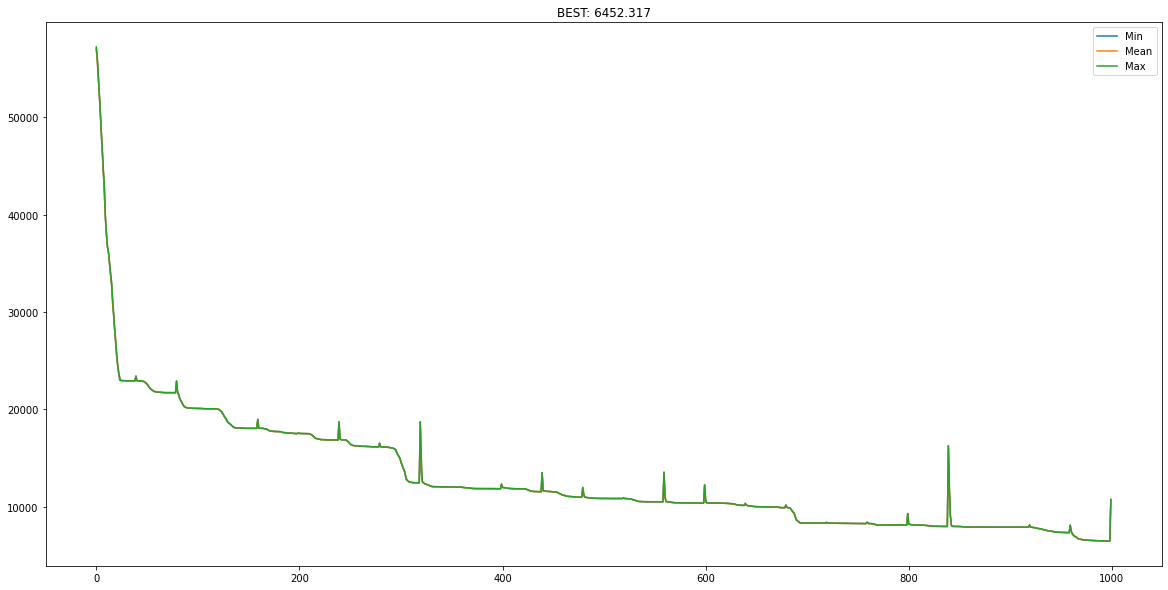

In [392]:
img = Image.open("../images/easy225x225.png").convert("RGB")

u = ImageGAIncremental2(img, population_size=2, children_size=150,
                       tick=10, gif_name="easy225x225inc1000mut1from2", iterations=1000, increment=40, to_mutate=2, individual_size=3)
u.run()
u.plot_cost()
print("number of triangles used: ", u.individual_size)


Evolving: 100%|██████████| 1000/1000 [08:41<00:00,  1.92it/s]


number of triangles used:  28


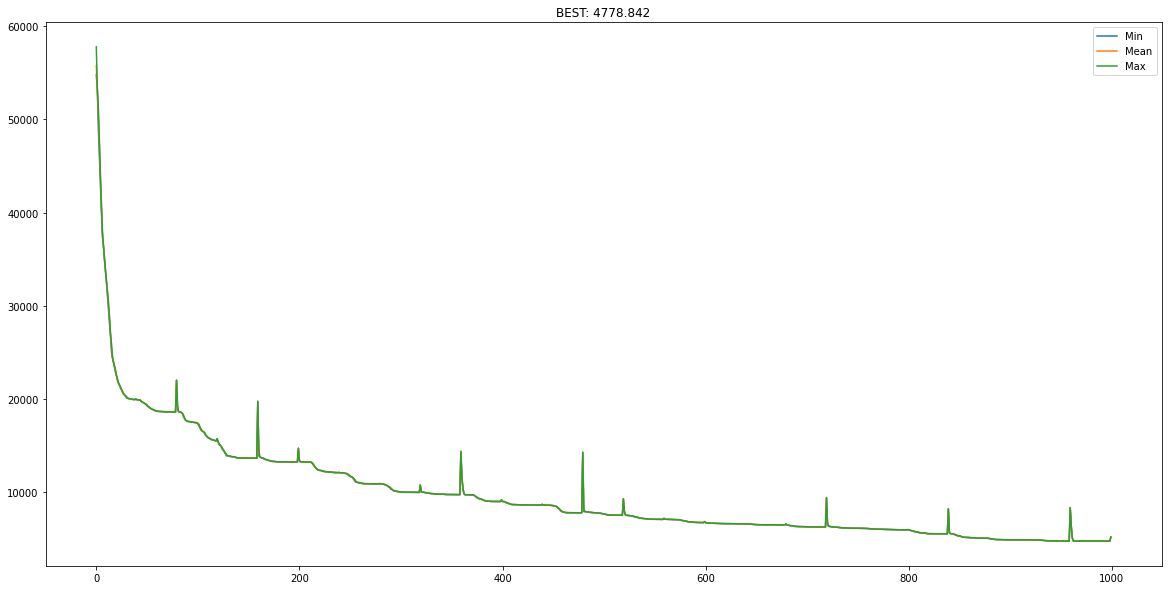

In [401]:
v = ImageGAIncremental2(img, population_size=3, children_size=150,
                        tick=10, gif_name="easy225x225inc1000mut1from3", iterations=1000, increment=40, to_mutate=3, individual_size=3)
v.run()
v.plot_cost()
print("number of triangles used: ", u.individual_size)


Evolving: 100%|██████████| 1000/1000 [05:54<00:00,  2.82it/s]


number of triangles used:  28


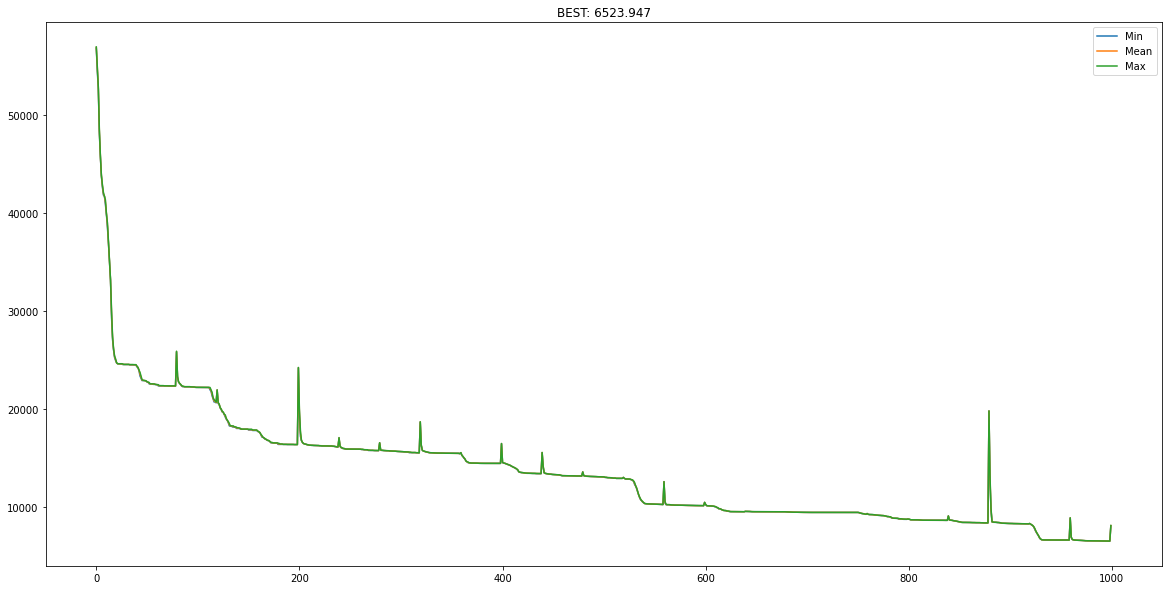

In [394]:
u = ImageGAIncremental(img, population_size=2, children_size=150,
                        tick=10, gif_name="easy225x225inc1000mut2from2", iterations=1000, increment=40, to_mutate=2, individual_size=3)
u.run()
u.plot_cost()
print("number of triangles used: ", u.individual_size)


Evolving: 100%|██████████| 1000/1000 [09:02<00:00,  1.84it/s]


number of triangles used:  28


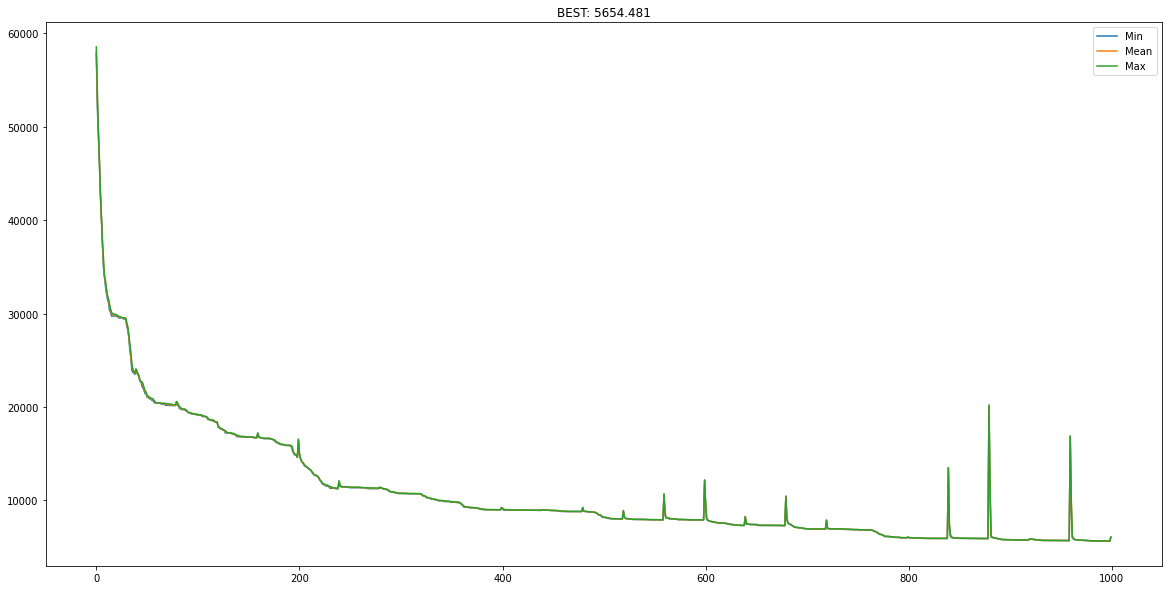

In [395]:
v = ImageGAIncremental(img, population_size=3, children_size=150,
                        tick=10, gif_name="easy225x225inc1000mut3from3", iterations=1000, increment=40, to_mutate=3, individual_size=3)
v.run()
v.plot_cost()
print("number of triangles used: ", u.individual_size)


Evolving: 100%|██████████| 1000/1000 [10:39<00:00,  1.56it/s]


number of triangles used:  28


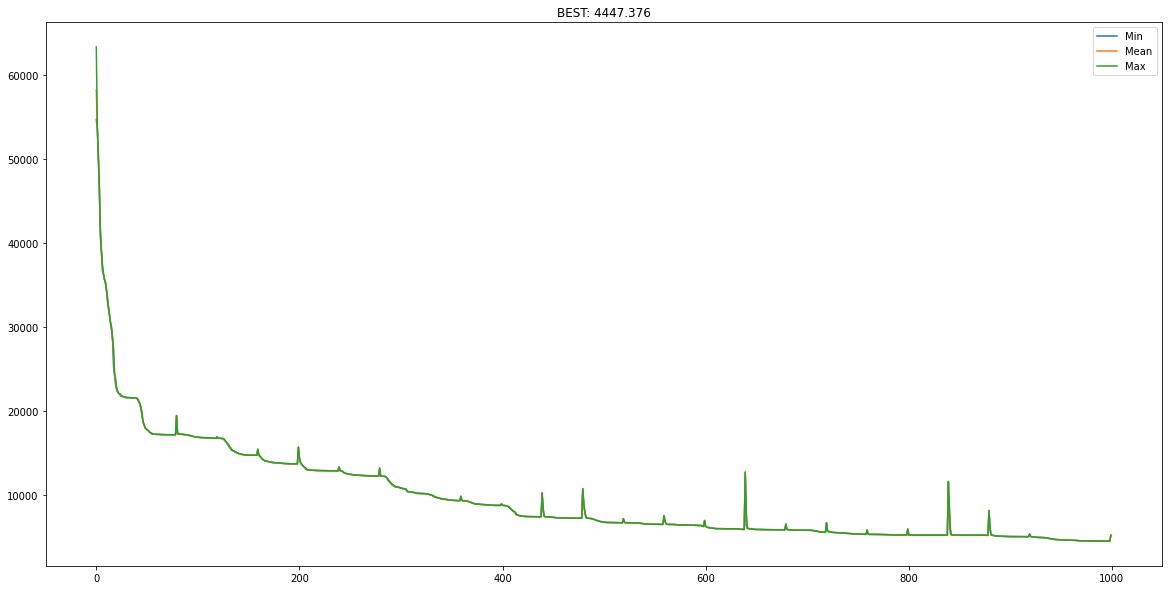

In [400]:
x = ImageGAIncremental2(img, population_size=4, children_size=150,
                        tick=10, gif_name="easy225x225inc1000mut1from4", iterations=1000, increment=40, to_mutate=4, individual_size=3)
x.run()
x.plot_cost()
print("number of triangles used: ", x.individual_size)


Evolving: 100%|██████████| 5000/5000 [1:31:38<00:00,  1.10s/it]


number of triangles used:  92


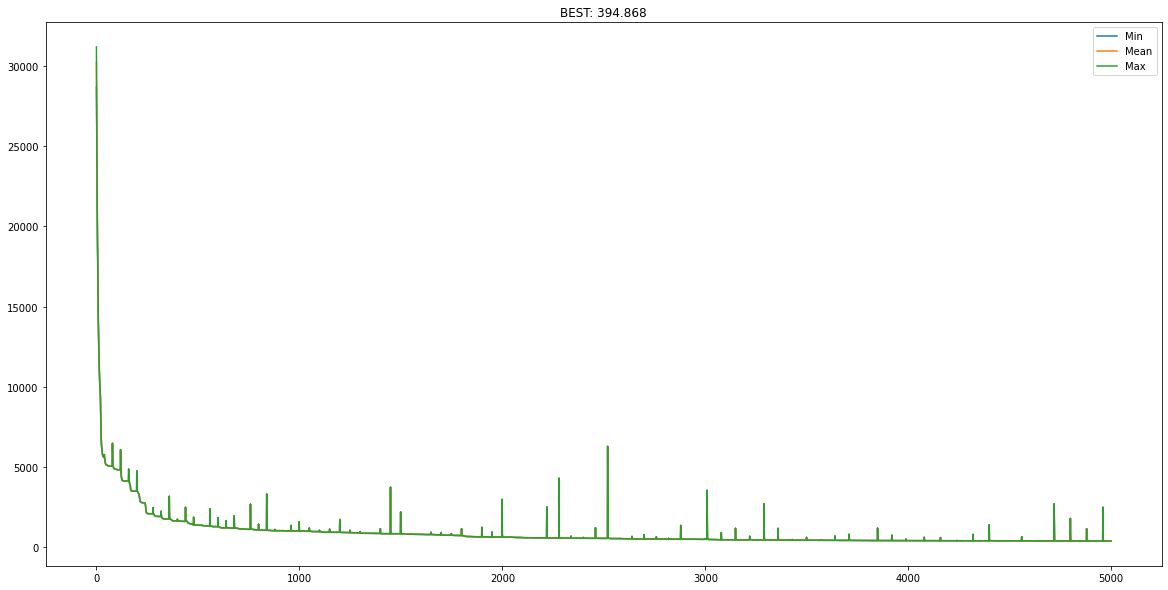

In [406]:
img = Image.open("../images/lisa256x256.jpg").convert("RGB")

u = ImageGAIncremental2(img, population_size=3, children_size=150,
                        tick=10, gif_name="lisa256x256inc5000mut1from3", iterations=5000, increment=40, to_mutate=3, individual_size=3)
u.run()
u.plot_cost()
print("number of triangles used: ", u.individual_size)


Evolving: 100%|██████████| 20000/20000 [10:41:59<00:00,  1.93s/it] 


number of triangles used:  195


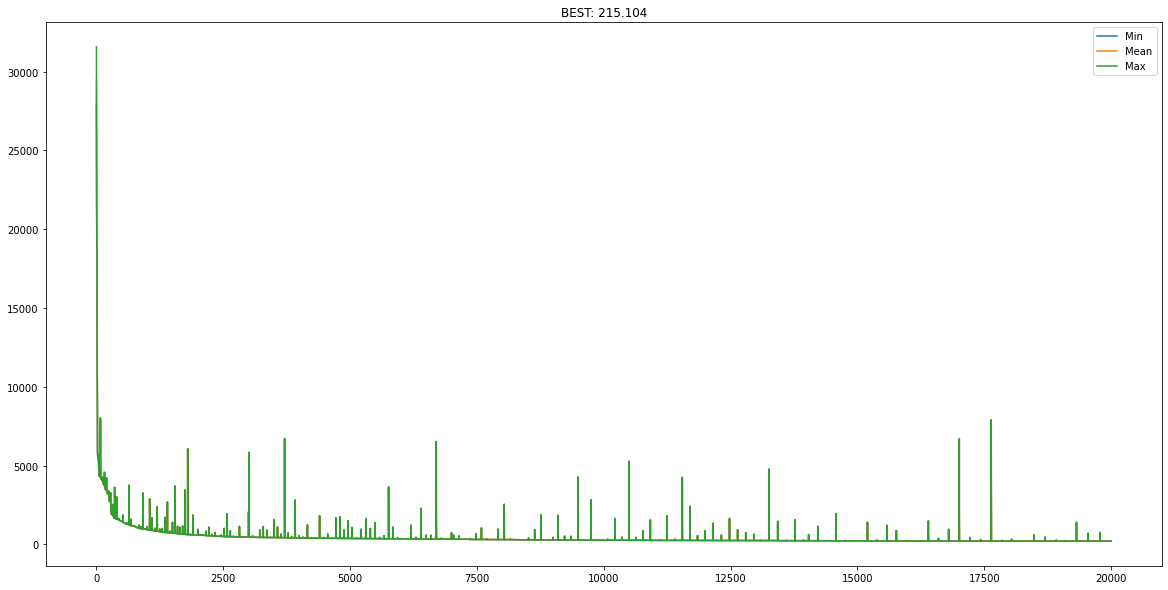

In [407]:
u = ImageGAIncremental2(img, population_size=3, children_size=150,
                        tick=10, gif_name="lisa256x256inc20000mut1from3", iterations=20000, increment=40, to_mutate=3, individual_size=3)
u.run()
u.plot_cost()
print("number of triangles used: ", u.individual_size)


Evolving: 100%|██████████| 5000/5000 [5:15:52<00:00,  3.79s/it]  


number of triangles used:  92


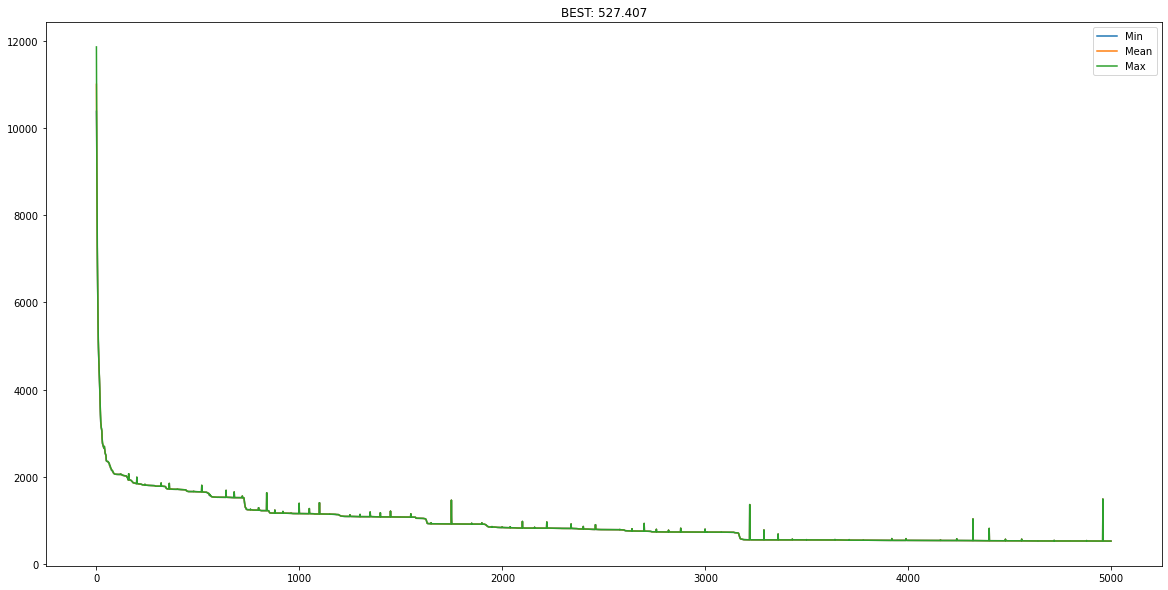

In [409]:
img = Image.open("../images/lisa-difficult514x767.jpg").convert("RGB")
u = ImageGAIncremental2(img, population_size=3, children_size=150,
                        tick=20, gif_name="lisa-diff-inc5000mut1from3", iterations=5000, increment=40, to_mutate=3, individual_size=3)
u.run()
u.plot_cost()
print("number of triangles used: ", u.individual_size)


Evolving: 100%|██████████| 3000/3000 [1:28:35<00:00,  1.77s/it]  


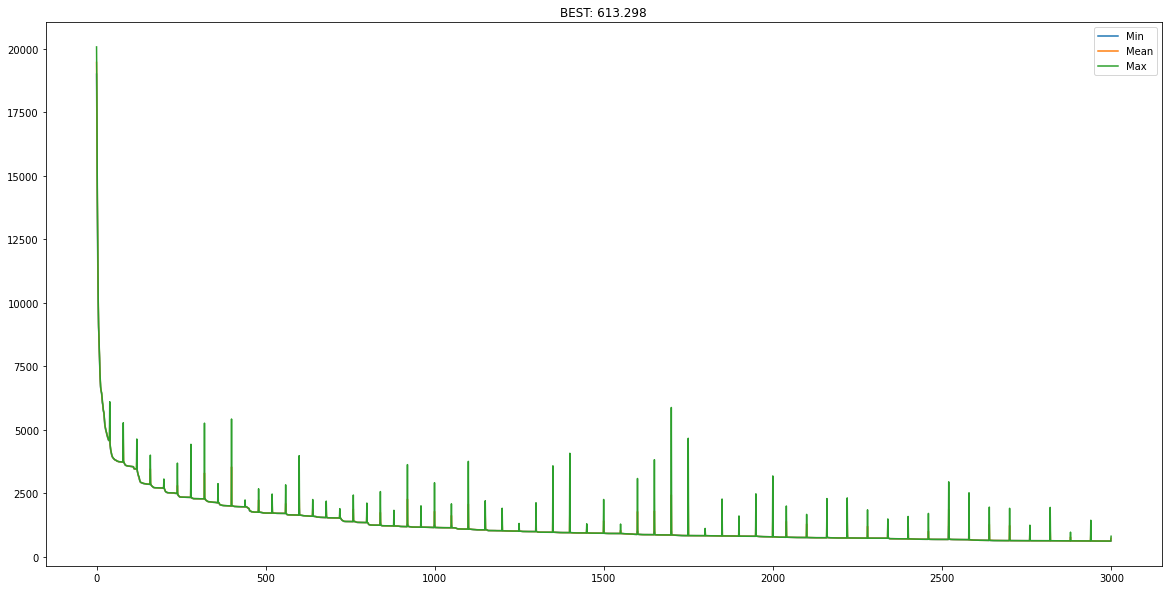

In [429]:
img = Image.open("../images/lisa268x400.jpg").convert("RGB")
u = ImageGAIncremental2(img, population_size=4, children_size=150,
                        tick=5, gif_name="test", iterations=3000, increment=40, to_mutate=3, individual_size=3)
u.run()
u.plot_cost()


Evolving: 100%|██████████| 25000/25000 [21:59:04<00:00,  3.17s/it]   


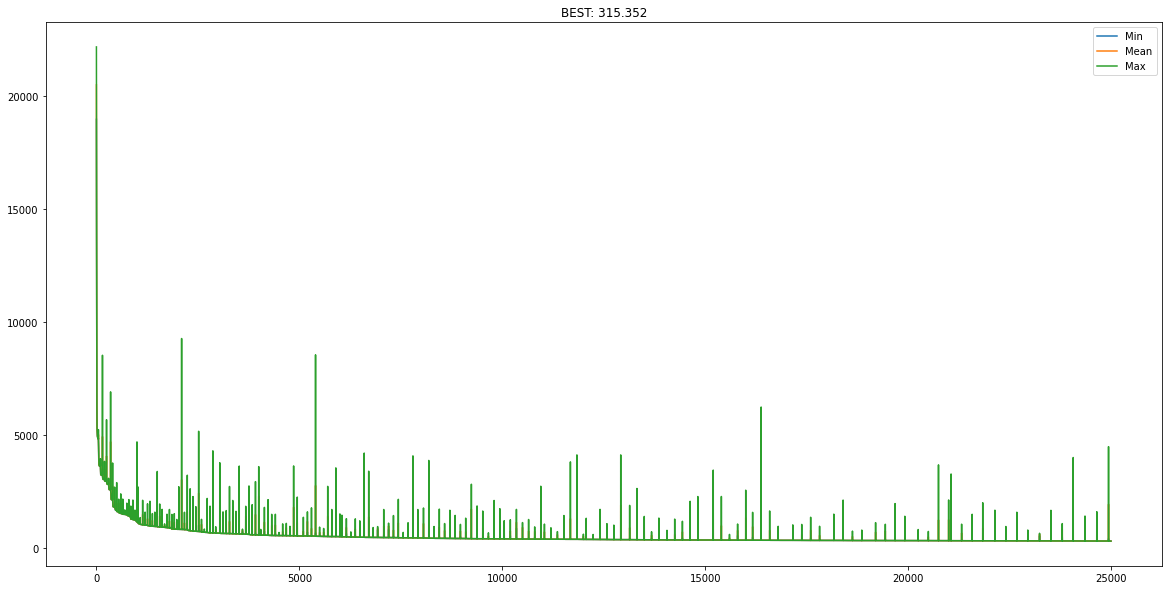

In [430]:
u = ImageGAIncremental2(img, population_size=4, children_size=150,
                        tick=50, gif_name="lisa-medium-25000it", iterations=25000, increment=50, to_mutate=3, individual_size=3)
u.run()
u.plot_cost()


In [438]:
class ImageGAIncremental3:
   def __init__(self, image, population, gif_name="default", iterations=100000, polygon_vertices=3, children_size=150, tick=50, to_mutate=3, increment=100):
      self.og_image = image
      self.og_image_data = np.asarray(self.og_image, dtype=np.int32)
      self.img_w, self.img_h = self.og_image.size
      self.iterations = iterations
      self.population_size = population.shape[0]
      self.children_size = children_size
      self.individual_size = population.shape[1]
      self.gif_name = gif_name
      self.population = population
      self.fitness_history = []
      self.gif_frames = []
      self.polygon_vertices = polygon_vertices
      self.tick = tick
      self.global_best = 100000000000
      self.to_mutate = to_mutate
      self.increment = increment

   def get_individual(self):
      return np.array([Polygon(self.polygon_vertices, [self.img_w, self.img_h]) for _ in range(self.individual_size)])

   def get_random_population(self):
      return np.array([self.get_individual() for _ in range(self.population_size)])

   def mutate(self, individual_og):
      individual = deepcopy(individual_og)
      id = np.random.randint(low=individual.size -
                             self.to_mutate, high=individual.size)
      pol = individual[id]
      for i in range(4):
         pol.rgba[i] = min(max(0, np.random.normal(pol.rgba[i], 15)), 255)
      id = np.random.randint(
          low=0, high=self.polygon_vertices, size=1)

      new_cords = np.random.normal(
          pol.cords[id], [self.img_w / 8, self.img_h / 8])
      new_cords[new_cords < 0] = 0
      if new_cords[0][0] > self.img_w:
         new_cords[0][0] = self.img_w
      if new_cords[0][1] > self.img_h:
         new_cords[0][1] = self.img_h
      pol.cords[id] = new_cords
      return individual

   def get_image(self, individual):
      image = Image.new("RGB", (self.img_w, self.img_h))
      draw = ImageDraw.Draw(image, "RGBA")
      for pol in individual:
         draw.polygon(tuple(map(tuple, pol.cords)), tuple(pol.rgba))
      return image

   def objective_function(self, individual):
      image_data = np.asarray(self.get_image(individual), dtype=np.int32)
      return np.sum((image_data - self.og_image_data)**2 / (self.img_w * self.img_h))

   def best_idx(self, p_v, k):
       return np.argpartition(p_v, k)[:k]

   def run(self):
      for t in tqdm(range(self.iterations), desc=f'Evolving'):
         if (t + 1) % self.increment == 0:
            self.individual_size += 1
            arr = np.array([Polygon(self.polygon_vertices, [
                           self.img_w, self.img_h]) for _ in range(self.population_size)])
            self.population = np.concatenate(
                (self.population, arr[:, None]), axis=1)

         population_values = np.array(
             [self.objective_function(x) for x in self.population])
         self.population = np.array([self.population[i] for i, _ in sorted(
             enumerate(population_values), key=lambda x: x[1])])
         population_values.sort()

         self.fitness_history.append(population_values.min())

         new_population = []

         for i in range(self.population_size):
            for j in range(self.children_size):
               new_population.append(self.mutate(self.population[i]))

         new_population = np.array(new_population)
         new_population_values = np.array(
             [self.objective_function(x) for x in new_population])
         new_population = np.array([new_population[i] for i, _ in sorted(
             enumerate(new_population_values), key=lambda x: x[1])])
         new_population_values.sort()

         self.population = np.concatenate((self.population, new_population))
         population_values = np.concatenate(
             (population_values, new_population_values))

         self.population = np.array([self.population[i] for i, _ in sorted(
             enumerate(population_values), key=lambda x: x[1])][:self.population_size])

         best_guy = self.population[0]
         self.global_best = min(self.global_best, population_values[0])

         gif_frame = self.get_image(best_guy)
         if t % self.tick == 0:
            gif_frame.save(self.gif_name + '.png', quality='keep')
            self.gif_frames.append(gif_frame)

      gif_frame.save(self.gif_name + '.png', quality='keep')
      self.gif_frames.append(gif_frame)
      self.gif_frames[0].save(self.gif_name+'.gif', format='GIF',
                              append_images=self.gif_frames[1:], save_all=True, duration=4, loop=0)

   def plot_cost(self):
       plt.figure(figsize=(20, 10))
       plt.plot(self.fitness_history)
       plt.title(f'BEST: {self.global_best :.3f}')
       plt.legend(['Min'], loc='upper right')


Evolving: 100%|██████████| 10098/10098 [13:11:36<00:00,  4.70s/it] 


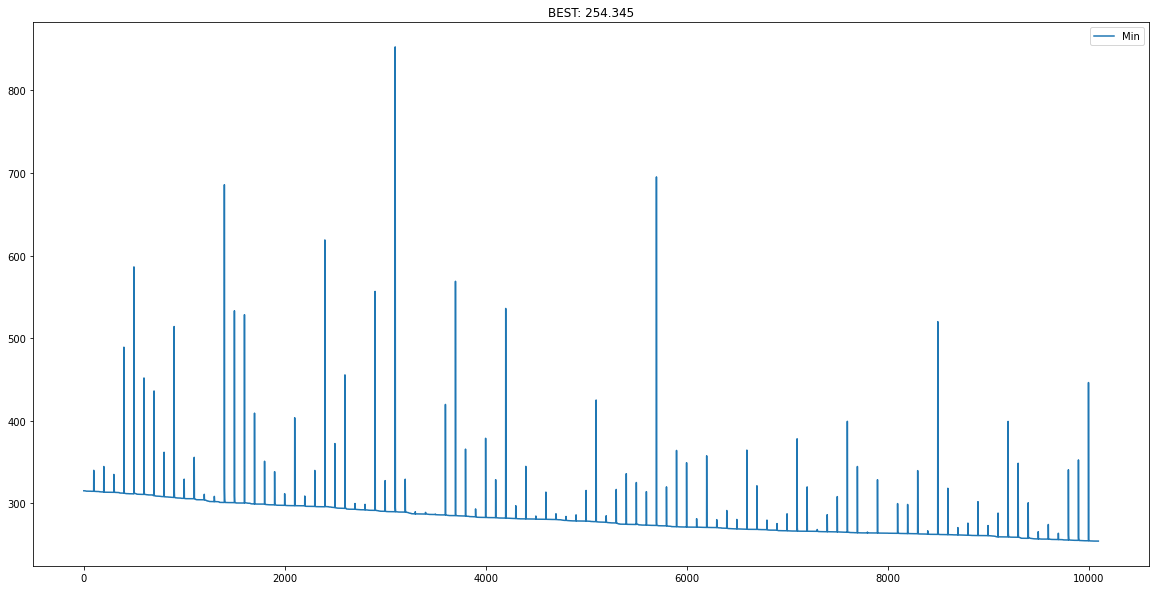

In [441]:
u2 = ImageGAIncremental3(img, deepcopy(u.population), gif_name="lisa-medium-continuation", iterations=10098)
u2.run()
u2.plot_cost()

In [444]:
print("triangles used: ", u2.individual_size)
population = u2.population[:1]

triangles used:  290


In [456]:
class ImageGAIncremental1ParentContinuation:
   def __init__(self, image, population, gif_name="default", iterations=100000, polygon_vertices=3, children_size=150, tick=50, to_mutate=3, increment=50):
      self.og_image = image
      self.og_image_data = np.asarray(self.og_image, dtype=np.int32)
      self.img_w, self.img_h = self.og_image.size
      self.img_obj = Image.new("RGB", (self.img_w, self.img_h))
      self.iterations = iterations
      self.population_size = 1
      self.children_size = children_size
      self.individual_size = population.shape[1]
      self.gif_name = gif_name
      self.population = population
      self.fitness_history = []
      self.gif_frames = []
      self.polygon_vertices = polygon_vertices
      self.tick = tick
      self.global_best = 100000000000
      self.to_mutate = to_mutate
      self.increment = increment

   def get_individual(self):
      return np.array([Polygon(self.polygon_vertices, [self.img_w, self.img_h]) for _ in range(self.individual_size)])

   def get_random_population(self):
      return np.array([self.get_individual() for _ in range(self.population_size)])

   def mutate(self, individual_og):
      individual = deepcopy(individual_og)
      id = np.random.randint(low=individual.size -
                             self.to_mutate, high=individual.size)
      pol = individual[id]
      for i in range(4):
         pol.rgba[i] = min(max(0, np.random.normal(pol.rgba[i], 15)), 255)
      id = np.random.randint(
          low=0, high=self.polygon_vertices, size=1)

      new_cords = np.random.normal(
          pol.cords[id], [self.img_w / 8, self.img_h / 8])
      new_cords[new_cords < 0] = 0
      if new_cords[0][0] > self.img_w:
         new_cords[0][0] = self.img_w
      if new_cords[0][1] > self.img_h:
         new_cords[0][1] = self.img_h
      pol.cords[id] = new_cords
      return individual

   def get_image(self, individual):
      image = deepcopy(self.img_obj)
      draw = ImageDraw.Draw(image, "RGBA")
      for i in range(individual.size - self.to_mutate, individual.size):
         pol = individual[i]
         draw.polygon(tuple(map(tuple, pol.cords)), tuple(pol.rgba))
      return image

   def objective_function(self, individual):
      image_data = np.asarray(self.get_image(individual), dtype=np.int32)
      return np.sum((image_data - self.og_image_data)**2 / (self.img_w * self.img_h))

   def best_idx(self, p_v, k):
       return np.argpartition(p_v, k)[:k]

   def run(self):
      draw = ImageDraw.Draw(self.img_obj, "RGBA")
      for i in range(self.individual_size - self.to_mutate):
         draw.polygon(
             tuple(map(tuple, self.population[0][i].cords)),tuple(self.population[0][i].rgba)
             )

      for t in tqdm(range(self.iterations), desc=f'Evolving'):
         if (t + 1) % self.increment == 0:
            self.individual_size += 1
            draw = ImageDraw.Draw(self.img_obj, "RGBA")
            draw.polygon(
                tuple(
                    map(tuple, self.population[0][self.individual_size-self.to_mutate-1].cords)),
                tuple(self.population[0][self.individual_size-self.to_mutate-1].rgba))

            arr = np.array([Polygon(self.polygon_vertices, [
                           self.img_w, self.img_h]) for _ in range(self.population_size)])
            self.population = np.concatenate(
                (self.population, arr[:, None]), axis=1)

         population_values = np.array(
             [self.objective_function(x) for x in self.population])
         self.population = np.array([self.population[i] for i, _ in sorted(
             enumerate(population_values), key=lambda x: x[1])])
         population_values.sort()

         if (t + 1) % self.increment != 0:
            self.fitness_history.append(population_values[0])

         new_population = []

         for i in range(self.population_size):
            for j in range(self.children_size):
               new_population.append(self.mutate(self.population[i]))

         new_population = np.array(new_population)
         new_population_values = np.array(
             [self.objective_function(x) for x in new_population])
         new_population = np.array([new_population[i] for i, _ in sorted(
             enumerate(new_population_values), key=lambda x: x[1])])
         new_population_values.sort()

         self.population = np.concatenate((self.population, new_population))
         population_values = np.concatenate(
             (population_values, new_population_values))

         self.population = np.array([self.population[i] for i, _ in sorted(
             enumerate(population_values), key=lambda x: x[1])][:self.population_size])

         best_guy = self.population[0]
         self.global_best = min(self.global_best, population_values[0])

         gif_frame = self.get_image(best_guy)
         if t % self.tick == 0:
            gif_frame.save(self.gif_name + '.png', quality='keep')
            self.gif_frames.append(gif_frame)


      gif_frame.save(self.gif_name + '.png', quality='keep')
      self.gif_frames.append(gif_frame)
      self.gif_frames[0].save(self.gif_name+'.gif', format='GIF',
                              append_images=self.gif_frames[1:], save_all=True, duration=4, loop=0)

   def plot_cost(self):
       plt.figure(figsize=(20, 10))
       plt.plot(self.fitness_history)
       plt.title(f'BEST: {self.global_best :.3f}')
       plt.legend(['Min'], loc='upper right')


Evolving: 100%|██████████| 10199/10199 [5:40:26<00:00,  2.00s/it] 


triangles used:  340


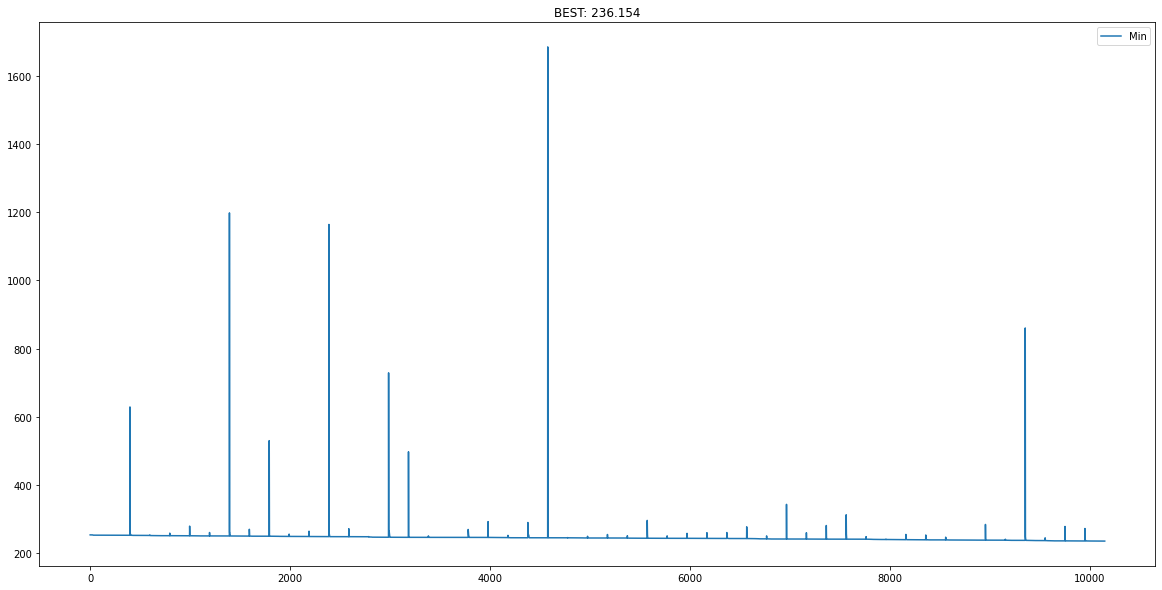

In [458]:
cont = ImageGAIncremental1ParentContinuation(img, deepcopy(population), gif_name="lisa-medium-1p-cont", iterations=10199, increment=200, children_size=500)
cont.run()
cont.plot_cost()
print("triangles used: ", cont.individual_size)


Evolving: 100%|██████████| 10199/10199 [5:50:25<00:00,  2.06s/it] 


triangles used:  373


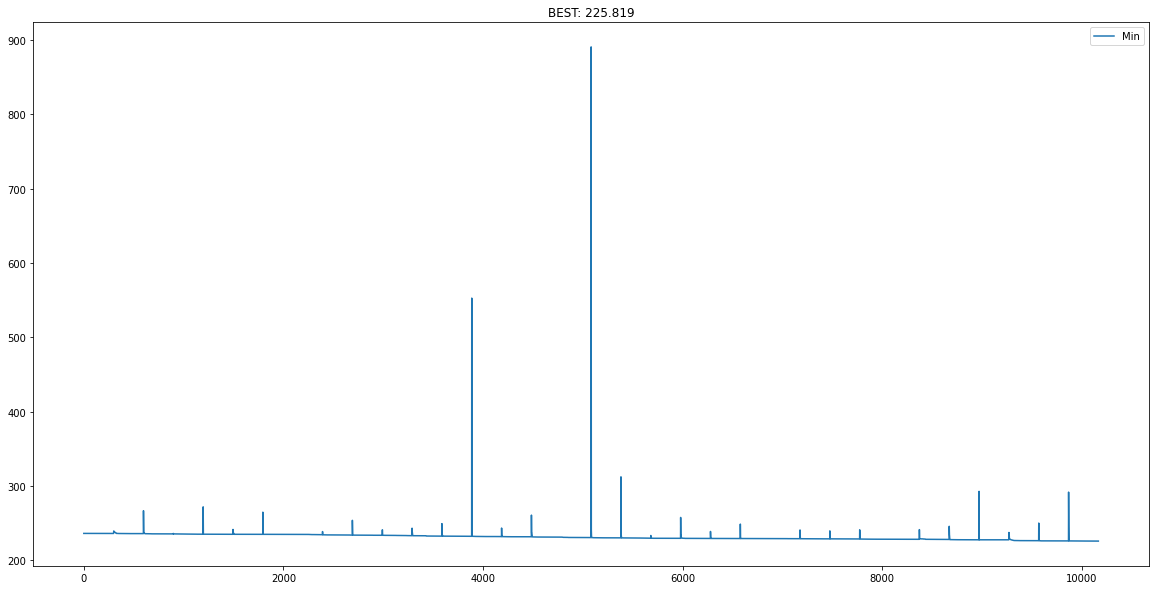

In [459]:
population2 = cont.population

cont2 = ImageGAIncremental1ParentContinuation(img, deepcopy(
    population2), gif_name="lisa-medium-1p-cont2", iterations=10199, increment=300, children_size=500)
cont2.run()
cont2.plot_cost()
print("triangles used: ", cont2.individual_size)
